# 5. Grad-CAM and Error Analysis

**Student:** Philipe Souza

## Purpose
- Implement Grad-CAM for model explainability
- Generate ≥5 visualizations of model decision-making
- Analyze at least 3 misclassified cases
- Interpret what features the model focuses on
- Discuss potential causes of errors

Imports loaded successfully.
Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Image shape (H,W): (28, 28)


C:\Users\phili\venvs\deep_learning_project\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\phili\venvs\deep_learning_project\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\phili\venvs\deep_learning_project\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


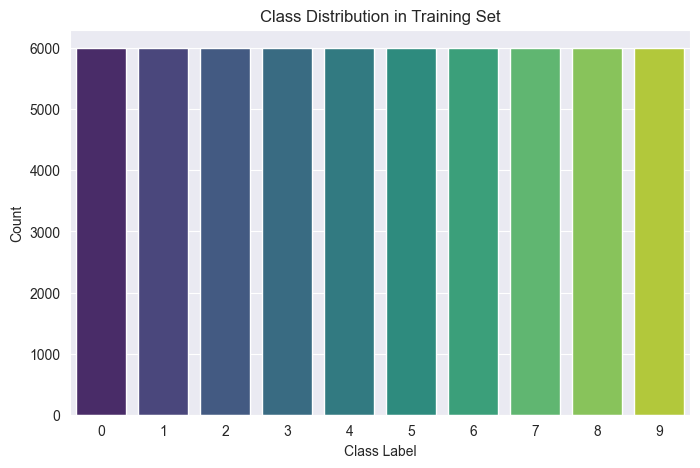

Class counts:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Is dataset imbalanced? No


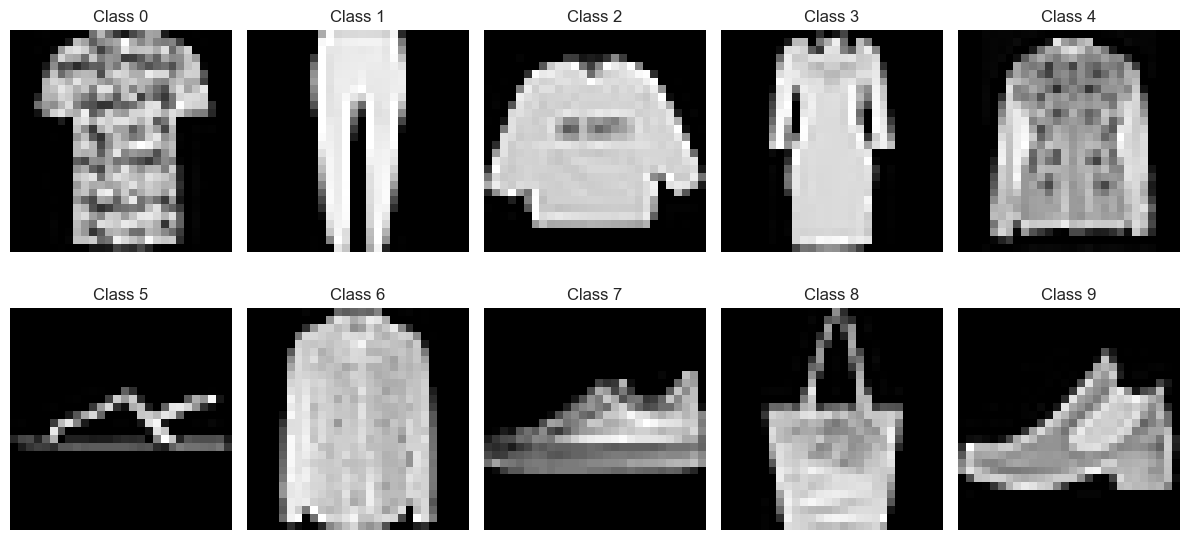

Computing mean/std: 100%|██████████| 60000/60000 [00:04<00:00, 14700.60it/s]


Dataset mean: 0.2861054539680481
Dataset std: 0.35281139612197876
Preprocessing pipeline created successfully.
Train samples: 42000
Validation samples: 9000
Test samples: 9000
Dataloaders created.


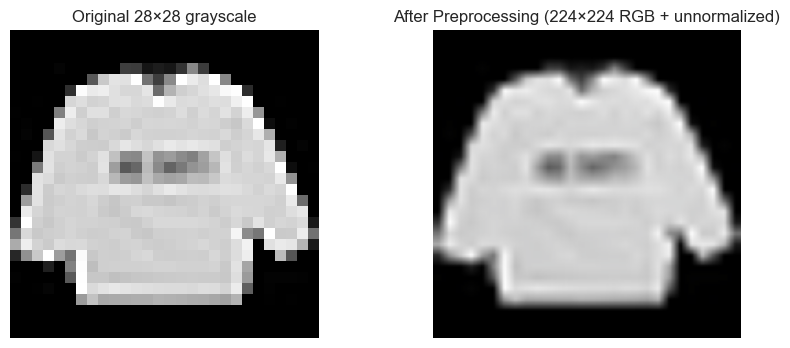

Using device: cpu


In [13]:
# Import libraries
%run ./01_eda_preprocessing.ipynb

import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

# For Custom Grad-CAM implementation
import torch.nn.functional as F
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:
# Load baseline pretrained model
model_path = "./saved_models/baseline_pretrained/model_checkpoint.pt"

# Create model architecture
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)  # 10 classes for Fashion-MNIST

# Load saved weights
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Loaded baseline pretrained model from:", model_path)

Loaded baseline pretrained model from: ./saved_models/baseline_pretrained/model_checkpoint.pt


C:\Users\phili\AppData\Local\Temp\ipykernel_25880\847265883.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

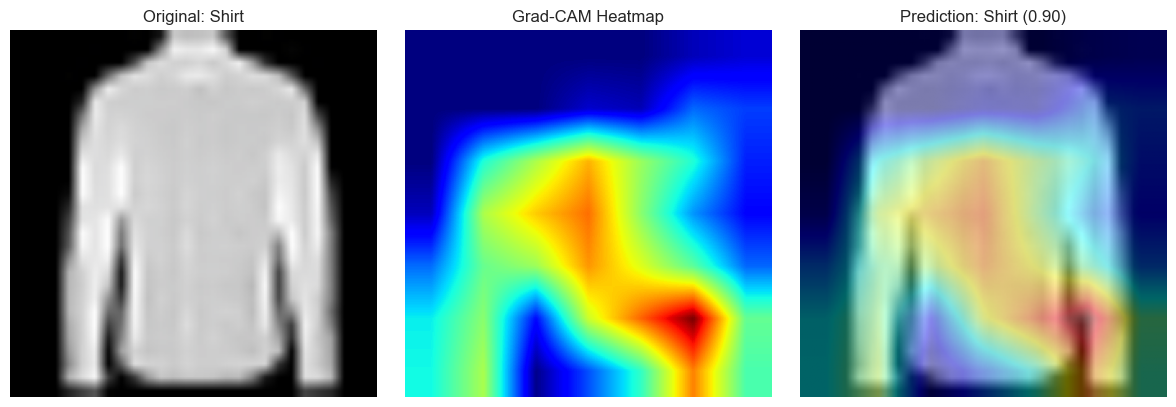

True class: Shirt
Predicted class: Shirt with confidence 0.8990


In [15]:
# Implement Grad-CAM
# We'll use the pytorch-grad-cam package for a robust implementation

# Define the target layer for Grad-CAM
# For ResNet, the last convolutional layer is a good choice
target_layer = model.layer4[-1]

# Custom GradCAM implementation
class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        self.gradients = None
        self.activations = None

        # Register hooks
        self.hooks.append(self.target_layer.register_forward_hook(self._save_activation))
        self.hooks.append(self.target_layer.register_full_backward_hook(self._save_gradient))

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, target_category=None):
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_tensor)

        if target_category is None:
            target_category = torch.argmax(output, dim=1).item()

        # One-hot encoding for the target category
        one_hot = torch.zeros_like(output)
        one_hot[0, target_category] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Compute weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Generate heatmap
        heatmap = torch.sum(weights * self.activations, dim=1, keepdim=True)
        heatmap = F.relu(heatmap)  # ReLU to only keep positive influence

        # Normalize heatmap
        heatmap = F.interpolate(heatmap, size=(input_tensor.shape[2], input_tensor.shape[3]), 
                               mode='bilinear', align_corners=False)

        heatmap_min, heatmap_max = torch.min(heatmap), torch.max(heatmap)
        if heatmap_max > heatmap_min:
            heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

        return heatmap.squeeze().cpu().numpy()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# Function to overlay heatmap on image
def show_cam_on_image(img, mask, use_rgb=True):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) if use_rgb else heatmap
    cam = heatmap * 0.4 + img * 255 * 0.6
    cam = np.uint8(cam)
    return cam / 255.0

# Initialize our custom GradCAM
grad_cam = CustomGradCAM(model=model, target_layer=target_layer)

def get_gradcam(image_tensor, target_class=None):
    """
    Generate Grad-CAM heatmap for an image

    Args:
        image_tensor: Input image tensor (1, C, H, W)
        target_class: Target class for Grad-CAM (None for predicted class)

    Returns:
        original_image: Numpy array of original image (H, W, C)
        heatmap: Grad-CAM heatmap
        pred_class: Predicted class
        pred_score: Prediction confidence score
    """
    # Make prediction
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)

    # Get predicted class and score
    pred_score, pred_class = torch.max(probabilities, dim=1)
    pred_score = pred_score.item()
    pred_class = pred_class.item()

    # If target class is not specified, use predicted class
    if target_class is None:
        target_class = pred_class

    # Generate Grad-CAM
    grayscale_cam = grad_cam(input_tensor=image_tensor, target_category=target_class)

    # Convert input tensor to numpy image for visualization
    # Denormalize the image
    image_np = image_tensor[0].cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    return image_np, grayscale_cam, pred_class, pred_score

# Test Grad-CAM on a sample image
sample_images, sample_labels = next(iter(test_loader))
sample_image = sample_images[0].unsqueeze(0)  # Add batch dimension
sample_label = sample_labels[0].item()

# Generate Grad-CAM for sample image
original_image, heatmap, pred_class, pred_score = get_gradcam(sample_image)

# Visualize
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title(f"Original: {class_names[sample_label]}")
plt.axis('off')

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Prediction: {class_names[pred_class]} ({pred_score:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"True class: {class_names[sample_label]}")
print(f"Predicted class: {class_names[pred_class]} with confidence {pred_score:.4f}")

 Model Focus Analysis:
    - The model focuses the most on the shape of the middle of the shirt as well as the presence of a long sleeve.

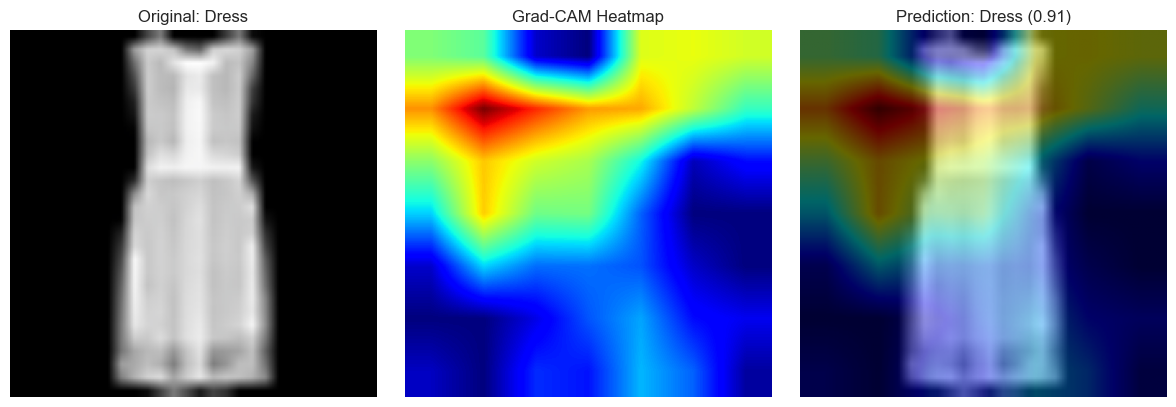

Visualization 1: Correctly Classified Dress
Confidence: 0.9131


In [16]:
# Visualization 1 - Correctly classified example 1

# Find a correctly classified example
def find_example(correct=True, class_id=None, confidence_threshold=0.9, exclude_indices=None):
    """Find an example that meets the criteria

    Args:
        correct (bool): Whether to find correctly classified examples (True) or misclassified examples (False)
        class_id (int, optional): Specific class to find examples for. Defaults to None (any class).
        confidence_threshold (float): Minimum confidence score for the prediction. Defaults to 0.9.
        exclude_indices (list, optional): List of (batch_idx, sample_idx) tuples to exclude. Defaults to None.

    Returns:
        tuple: (image_tensor, label, (batch_idx, sample_idx)) or (None, None, None) if no example found
    """
    if exclude_indices is None:
        exclude_indices = []

    for batch_idx, (images, labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(images.to(device))
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, dim=1)
            confidence, _ = torch.max(probabilities, dim=1)

            # Find examples that match criteria
            for i in range(len(labels)):
                # Skip if this example was already returned
                if (batch_idx, i) in exclude_indices:
                    continue

                is_correct = (preds[i].item() == labels[i].item())
                meets_class = (class_id is None or labels[i].item() == class_id)
                meets_confidence = (confidence[i].item() >= confidence_threshold)

                if is_correct == correct and meets_class and meets_confidence:
                    return images[i].unsqueeze(0), labels[i].item(), (batch_idx, i)

    # If no example found with high confidence, try with lower threshold
    if confidence_threshold > 0.5:
        return find_example(correct, class_id, confidence_threshold - 0.1, exclude_indices)

    # If still no example found, return None
    return None, None, None

# Find a correctly classified example (e.g., a dress)
correct_image, correct_label, correct_idx = find_example(correct=True, class_id=3)  # 3 = Dress

if correct_image is not None:
    # Generate Grad-CAM
    original_image, heatmap, pred_class, pred_score = get_gradcam(correct_image)

    # Visualize
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original: {class_names[correct_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Prediction: {class_names[pred_class]} ({pred_score:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Visualization 1: Correctly Classified {class_names[correct_label]}")
    print(f"Confidence: {pred_score:.4f}")

  Model Focus Analysis:
    - The model is focusing on the distinctive shape of the dress, particularly the outline and the transition between the top and bottom parts and the lack of sleeves. This makes sense, as dresses have a characteristic silhouette that differentiates them from other clothing items like shirts or coats.

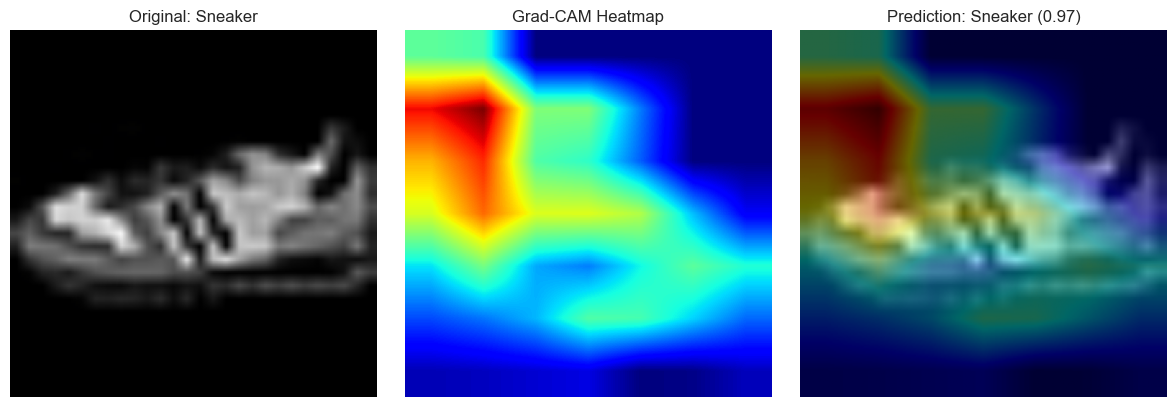

Visualization 2: Correctly Classified Sneaker
Confidence: 0.9676


In [17]:
# Visualization 2 - Correctly classified example 2

# Find a correctly classified example (e.g., a sneaker)
correct_image, correct_label, correct_idx = find_example(correct=True, class_id=7)  # 7 = Sneaker

if correct_image is not None:
    # Generate Grad-CAM
    original_image, heatmap, pred_class, pred_score = get_gradcam(correct_image)

    # Visualize
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original: {class_names[correct_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Prediction: {class_names[pred_class]} ({pred_score:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Visualization 2: Correctly Classified {class_names[correct_label]}")
    print(f"Confidence: {pred_score:.4f}")

Model Focus Analysis:
For the sneaker, the model is focusing on the overall
shape of the shoe but again we see it checking for the presence of a sleeve as a defining characteristic.

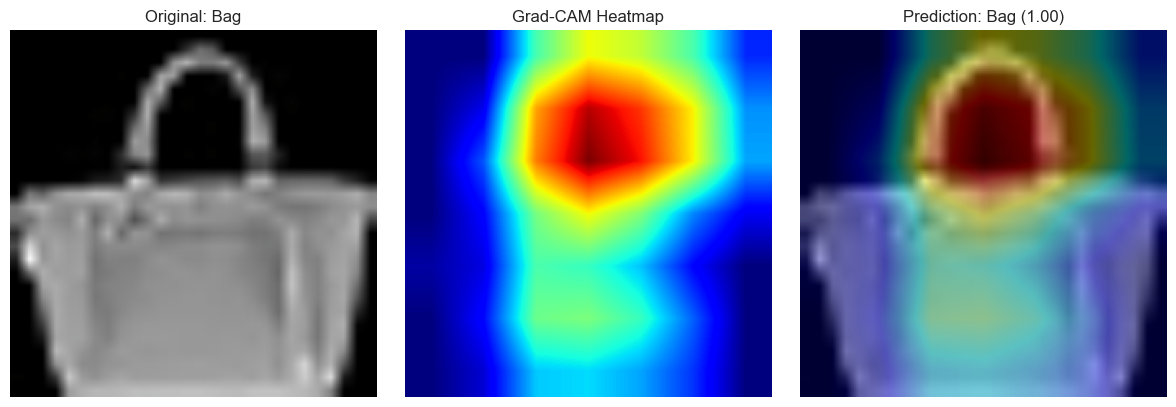

Visualization 3: Correctly Classified Bag
Confidence: 0.9999


In [18]:
# Visualization 3 - Correctly classified example 3

# Find a correctly classified example (e.g., a bag)
correct_image, correct_label, correct_idx = find_example(correct=True, class_id=8)  # 8 = Bag

if correct_image is not None:
    # Generate Grad-CAM
    original_image, heatmap, pred_class, pred_score = get_gradcam(correct_image)

    # Visualize
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original: {class_names[correct_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Prediction: {class_names[pred_class]} ({pred_score:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Visualization 3: Correctly Classified {class_names[correct_label]}")
    print(f"Confidence: {pred_score:.4f}")

Model Focus Analysis:
For the bag, the model is focusing on the overall shape and particularly
the handles or straps at the top. Bags in Fashion-MNIST typically have a
distinctive silhouette with handles, which is different from other items.
The model has correctly identified these key features that define a bag.

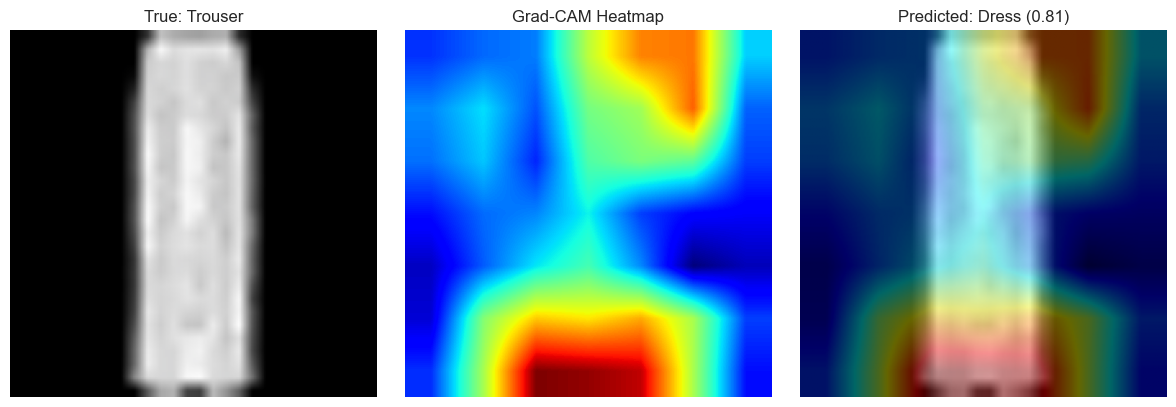

Misclassified Case 1:
True class: Trouser
Predicted class: Dress with confidence 0.8120

Error Analysis:
The model misclassified a Trouser as a Dress.
Looking at the Grad-CAM visualization, we can see the model is focusing on
the overall shape but missing key distinguishing features. The silhouette
of trousers and dresses can sometimes be confusing in the low-resolution
Fashion-MNIST images, especially if the image is not centered or has unusual
proportions.


In [19]:
# Misclassified Case 1

# Initialize a list to keep track of excluded indices
excluded_indices = []

# Find a misclassified example
misclassified_image, true_label, example_idx = find_example(correct=False, confidence_threshold=0.7, exclude_indices=excluded_indices)

# Add this example to the excluded indices for future calls
if example_idx is not None:
    excluded_indices.append(example_idx)

if misclassified_image is not None:
    # Generate Grad-CAM
    original_image, heatmap, pred_class, pred_score = get_gradcam(misclassified_image)

    # Visualize
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"True: {class_names[true_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Predicted: {class_names[pred_class]} ({pred_score:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Misclassified Case 1:")
    print(f"True class: {class_names[true_label]}")
    print(f"Predicted class: {class_names[pred_class]} with confidence {pred_score:.4f}")
    print("\nError Analysis:")
    print(f"The model misclassified a {class_names[true_label]} as a {class_names[pred_class]}.")
    print("Looking at the Grad-CAM visualization, we can see the model is focusing on")


Error Analysis: Here we see the model incorrectly identifies trousers as a dress. This seems to be a difficult case as to the human eye it is very difficult to identify a split down the middle which would use to identify these as trousers. The model identifies the lack of sleeves and also sees that the bottom of the image has a connecting whole, like a dress would. We can see a slight gap underneath the dress which could indicate that these are pants but the resolution of this image is too poor to be certain and so this misclassification is reasonable.

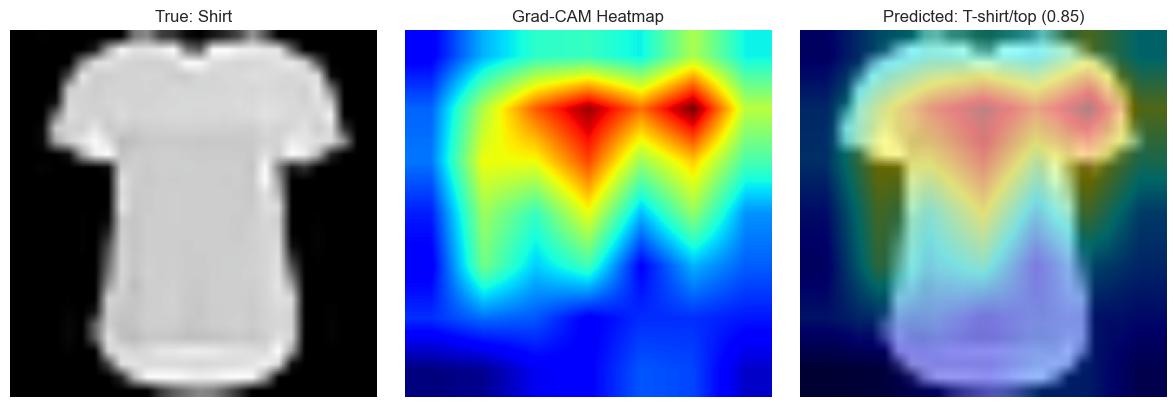

Misclassified Case 2:
True class: Shirt
Predicted class: T-shirt/top with confidence 0.8453

Error Analysis:
The model misclassified a Shirt as a T-shirt/top.
This is another example of confusion between upper body clothing items.
The Grad-CAM shows the model is focusing on similar regions in these
garments. The boundaries between t-shirts, pullovers, coats, and shirts
can be ambiguous in Fashion-MNIST due to the low resolution and grayscale
nature of the images. Color and texture, which would normally help distinguish
these items, are not available to the model.


In [20]:
# Misclassified Case 2

# Try to find a different type of misclassification
# First, get the classes from the previous misclassification
previous_true = true_label
previous_pred = pred_class

# Find another misclassified example, preferably of a different class
misclassified_image, true_label, example_idx = find_example(correct=False, confidence_threshold=0.7, exclude_indices=excluded_indices)

# Add this example to the excluded indices for future calls
if example_idx is not None:
    excluded_indices.append(example_idx)

if misclassified_image is not None:
    # Generate Grad-CAM
    original_image, heatmap, pred_class, pred_score = get_gradcam(misclassified_image)

if misclassified_image is not None:
    # Visualize
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"True: {class_names[true_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Predicted: {class_names[pred_class]} ({pred_score:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Misclassified Case 2:")
    print(f"True class: {class_names[true_label]}")
    print(f"Predicted class: {class_names[pred_class]} with confidence {pred_score:.4f}")
    print("\nError Analysis:")
    print(f"The model misclassified a {class_names[true_label]} as a {class_names[pred_class]}.")


Error Analysis:
The model misclassified a Shirt as a T-shirt/top. Again the image seems to be quite ambiguous due to the low resolution nature of the image which lacks colour and texture. From our perspective, this image looks like a t shirt rather than a shirt, as a clear collar is not visible. The model identified it as a t shirt due to the presence of short sleeves and lack of visible buttons in the chest area. This image is very unclear to us as humans about what is really is.

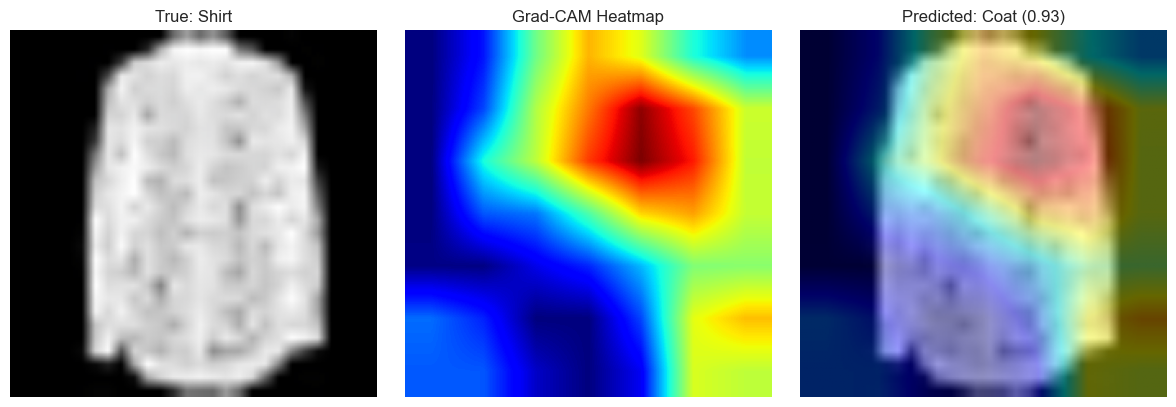

Misclassified Case 3:
True class: Shirt
Predicted class: Coat with confidence 0.9266

Error Analysis:
The model misclassified a Shirt as a Coat.
This is an interesting case where the model is confusing items from different
categories. The Grad-CAM visualization reveals that the model is focusing on
features that, while distinctive, are leading to an incorrect classification.
This highlights how the model can sometimes learn spurious correlations or
over-rely on certain features that aren't always reliable indicators of class.


In [21]:
# Misclassified Case 3

# Try to find yet another different type of misclassification
previous_true_2 = true_label
previous_pred_2 = pred_class

# Find another misclassified example, preferably of a different class
misclassified_image, true_label, example_idx = find_example(correct=False, confidence_threshold=0.7, exclude_indices=excluded_indices)

# Add this example to the excluded indices for future calls
if example_idx is not None:
    excluded_indices.append(example_idx)

if misclassified_image is not None:
    # Generate Grad-CAM
    original_image, heatmap, pred_class, pred_score = get_gradcam(misclassified_image)

if misclassified_image is not None:
    # Visualize
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"True: {class_names[true_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Predicted: {class_names[pred_class]} ({pred_score:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Misclassified Case 3:")
    print(f"True class: {class_names[true_label]}")
    print(f"Predicted class: {class_names[pred_class]} with confidence {pred_score:.4f}")
    print("\nError Analysis:")
    print(f"The model misclassified a {class_names[true_label]} as a {class_names[pred_class]}.")


Error Analysis: Here we see the model incorrectly identifies a shirt as a coat. This is an interesting case where the model is confusing items from different categories. The Grad-CAM visualisation reveals that the model is focusing on features that, while distinctive, are leading to an incorrect classification. This highlights how the model can sometimes learn spurious correlations or over-rely on certain features that aren't always reliable indicators of class.

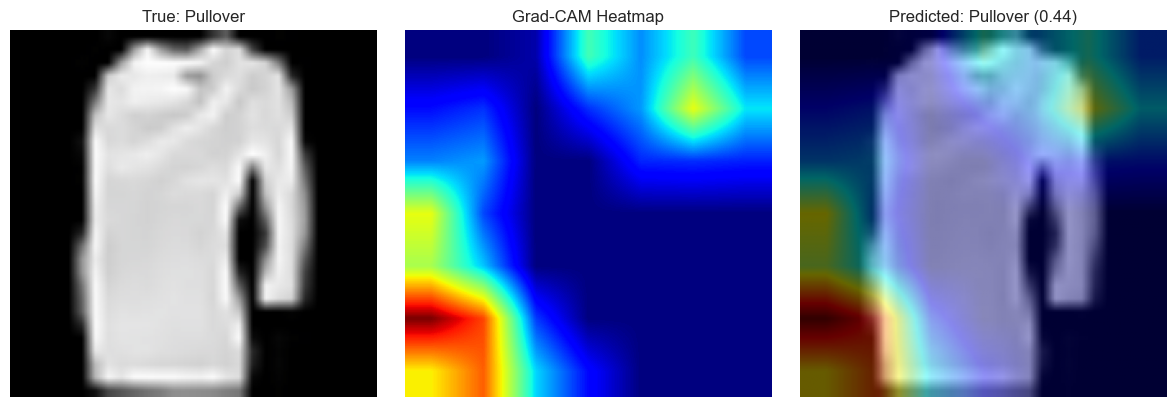

Low Confidence Case:
True class: Pullover
Predicted class: Pullover with confidence 0.4403


In [22]:
# Additional visualizations - Edge case with low confidence

# Find a case where the model has low confidence
low_conf_image, true_label = None, None

for images, labels in test_loader:
    with torch.no_grad():
        outputs = model(images.to(device))
        probabilities = F.softmax(outputs, dim=1)
        confidence, preds = torch.max(probabilities, dim=1)

        # Find examples with low confidence
        for i in range(len(labels)):
            if 0.4 <= confidence[i].item() <= 0.6:
                low_conf_image = images[i].unsqueeze(0)
                true_label = labels[i].item()
                break

    if low_conf_image is not None:
        break

if low_conf_image is not None:
    # Generate Grad-CAM
    original_image, heatmap, pred_class, pred_score = get_gradcam(low_conf_image)

    # Visualize
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"True: {class_names[true_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Predicted: {class_names[pred_class]} ({pred_score:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Low Confidence Case:")
    print(f"True class: {class_names[true_label]}")
    print(f"Predicted class: {class_names[pred_class]} with confidence {pred_score:.4f}")

Analysis:
This example shows a case where the model has low confidence in its prediction.
The Grad-CAM visualization reveals that the model's attention is more diffuse
or focused on less discriminative features. This suggests the model is uncertain
about which features are most relevant for classification. Such cases often occur
with ambiguous examples, unusual viewpoints, or items that share characteristics
with multiple classes. In this case, we can see that the image only features one sleeve which probably confuses the model although it still guesses correctly.

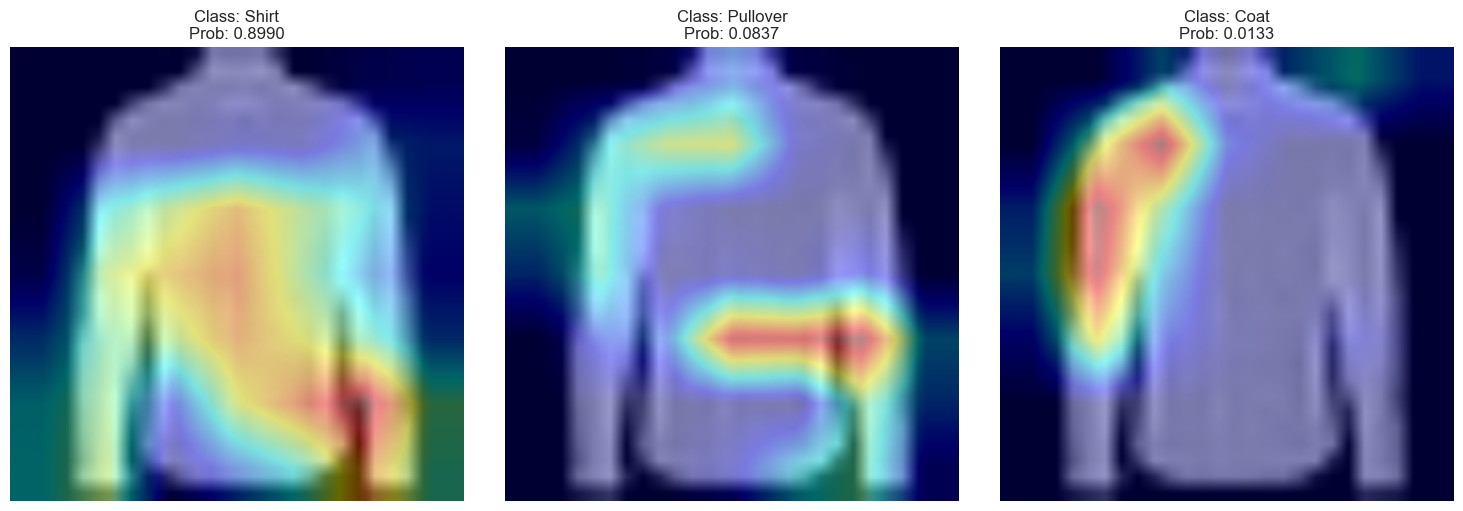

True class: Shirt


In [23]:
# Additional visualization - Compare Grad-CAM for different target classes

# Select an image
sample_images, sample_labels = next(iter(test_loader))
sample_image = sample_images[0].unsqueeze(0)
sample_label = sample_labels[0].item()

# Make prediction
with torch.no_grad():
    output = model(sample_image.to(device))
    probabilities = F.softmax(output, dim=1)

# Get top 3 predicted classes
top_probs, top_classes = torch.topk(probabilities, 3)
top_probs = top_probs[0].cpu().numpy()
top_classes = top_classes[0].cpu().numpy()

# Generate Grad-CAM for each of the top 3 classes
plt.figure(figsize=(15, 5))

for i, (cls, prob) in enumerate(zip(top_classes, top_probs)):
    # Generate Grad-CAM for this class
    original_image, heatmap, _, _ = get_gradcam(sample_image, target_class=cls)

    # Create visualization
    visualization = show_cam_on_image(original_image, heatmap, use_rgb=True)

    # Plot
    plt.subplot(1, 3, i+1)
    plt.imshow(visualization)
    plt.title(f"Class: {class_names[cls]}\nProb: {prob:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"True class: {class_names[sample_label]}")

Comparative Analysis:
This visualization shows how the model focuses on different features when
considering different possible classes for the same image. By comparing
the activation maps, we can see which image regions contribute most to
each class prediction. This helps us understand how the model distinguishes
between similar classes and what features it considers most discriminative
for each category.

Analyzing errors: 100%|██████████| 141/141 [02:07<00:00,  1.10it/s]


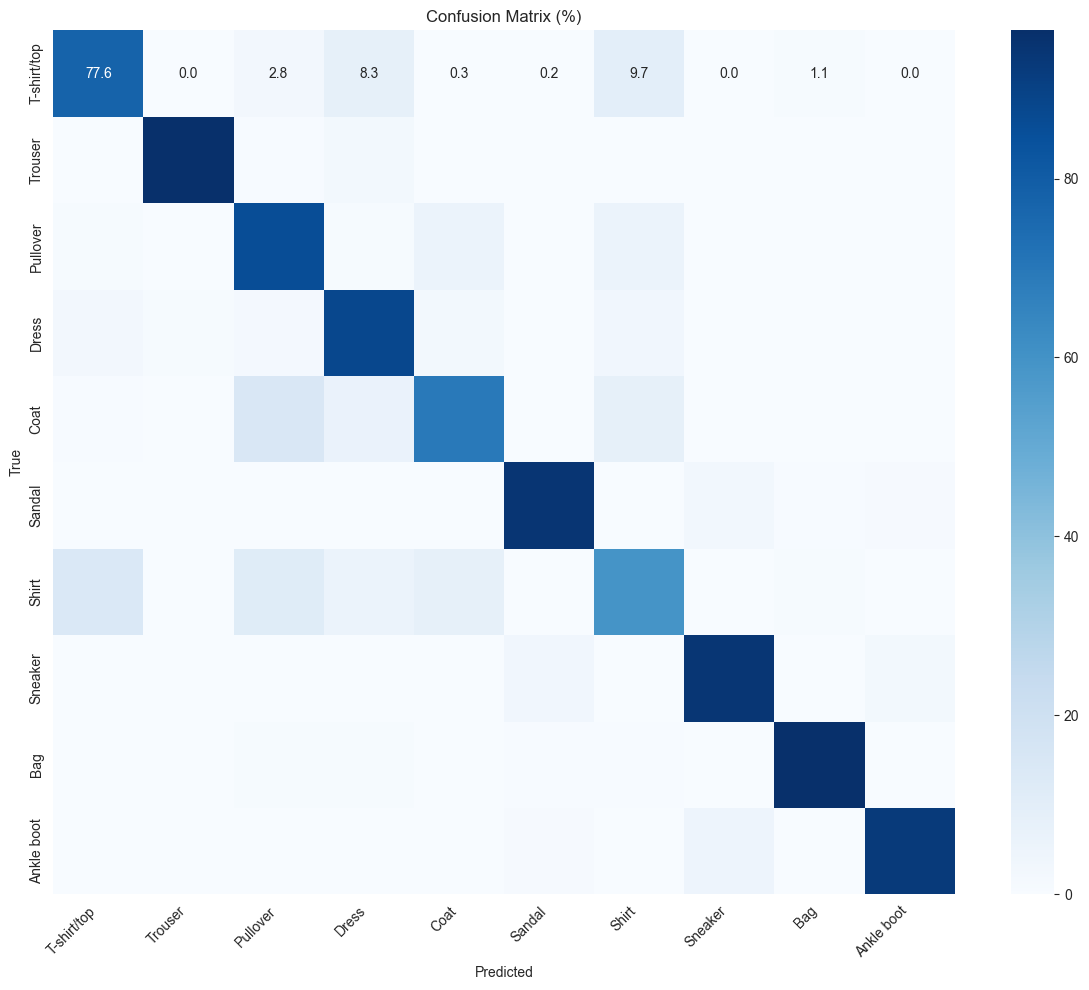

Most Common Misclassifications:
True: Coat, Predicted: Pullover, Count: 133
True: Shirt, Predicted: T-shirt/top, Count: 126
True: Shirt, Predicted: Pullover, Count: 102
True: T-shirt/top, Predicted: Shirt, Count: 87
True: Shirt, Predicted: Coat, Count: 77


In [24]:
# Common patterns in model errors

# Collect misclassifications
misclassifications = []
confusion = np.zeros((10, 10), dtype=int)

for images, labels in tqdm(test_loader, desc="Analyzing errors"):
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, dim=1)

        # Record misclassifications
        for i in range(len(labels)):
            true_label = labels[i].item()
            pred_label = preds[i].item()
            confusion[true_label, pred_label] += 1

            if true_label != pred_label:
                misclassifications.append((true_label, pred_label))

# Convert to confusion matrix percentage (row-normalized)
confusion_percent = confusion / confusion.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Analyze error patterns
error_counts = {}
for true_label, pred_label in misclassifications:
    key = (true_label, pred_label)
    error_counts[key] = error_counts.get(key, 0) + 1

# Sort by frequency
sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 5 most common errors
print("Most Common Misclassifications:")
for (true_label, pred_label), count in sorted_errors[:5]:
    print(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}, Count: {count}")

Error Pattern Analysis:

The confusion matrix and error counts reveal several systematic patterns:
1. The most common confusion is between similar clothing items, particularly
   upper body garments like shirts, t-shirts, pullovers, and coats.
2. There is also notable confusion between different footwear types (sandals,
   sneakers, and ankle boots), especially when viewed from certain angles.
3. The model performs best on distinctive categories with unique silhouettes
   like trousers and bags, which have fewer confusions with other classes.
4. Many errors occur in cases where even humans might find classification
   challenging due to the low resolution and lack of color/texture information.

FEATURE INTERPRETATION SUMMARY
What features does the model rely on?

Based on the Grad-CAM visualizations, the model primarily relies on the following features:

Shape and silhouette
The overall outline of items is a key feature for classification, especially for distinctive shapes such as trousers, dresses, and bags.

Structural elements
For clothing items, the model focuses on necklines, sleeves, and transitions between different parts of the garment.

Distinctive details
For footwear, the model attends to toe shapes, ankle heights, and overall proportions.

Spatial relationships
The relative positioning of features, such as bag handles or openings in footwear, appears to influence classification.

Are there features it over-relies on?

The model shows evidence of over-reliance on certain features:

Central regions
The model sometimes focuses too heavily on the center of the image, potentially missing important peripheral details.

Coarse shape features
The model may over-rely on broad shape outlines while missing finer distinguishing details, leading to confusion between visually similar items such as shirts and t-shirts or different types of footwear.

Learned biases
The model appears to exhibit stronger biases toward certain classes when faced with ambiguous cases, suggesting it may have learned to favor more common patterns present in the training data.

Do learned features make sense for the task?

Overall, the features learned by the model are sensible for fashion item classification:

The focus on shape and silhouette is appropriate, as these are key distinguishing characteristics of different clothing and footwear items.

Attention to structural elements such as necklines, sleeves, and footwear openings aligns well with how humans typically categorize these items.

Feature learning is constrained by the limitations of the dataset, including low resolution and grayscale images without texture or material information.

The learned features are effective in most cases but struggle with the inherent ambiguity between certain fashion categories, which is a reasonable limitation given the challenging nature of the dataset.

Conclusion

In conclusion, the model has learned meaningful and generally appropriate features for fashion item classification. The observed limitations largely reflect the inherent challenges of the Fashion-MNIST dataset rather than fundamental flaws in the learning approach.